In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve


Load and Explore Data

In [5]:
df = pd.read_csv('ADMISSIONS.csv')

# Select relevant columns
df = df[['admission_type', 'admission_location', 'insurance', 'ethnicity',
         'marital_status', 'religion', 'diagnosis', 'hospital_expire_flag']]

# Drop rows with missing values for simplicity
df.dropna(inplace=True)

# Show class distribution
df['hospital_expire_flag'].value_counts()


,count
hospital_expire_flag,
0,83
1,30


Encode Categorical Variables

In [6]:
X = pd.get_dummies(df.drop('hospital_expire_flag', axis=1))
y = df['hospital_expire_flag']


Train-Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training and Evaluation
(Logistic Regression, Random Forest, XGBoost)

In [8]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\\n{name} Results:")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("F1 Score:", f1_score(y_test, preds))
    print("ROC AUC:", roc_auc_score(y_test, preds))


\nLogistic Regression Results:
Accuracy: 0.7391304347826086
F1 Score: 0.0
ROC AUC: 0.4722222222222222
\nRandom Forest Results:
Accuracy: 0.7391304347826086
F1 Score: 0.0
ROC AUC: 0.4722222222222222
\nXGBoost Results:
Accuracy: 0.7391304347826086
F1 Score: 0.25
ROC AUC: 0.5444444444444444


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:56:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


 Hyperparameter Tuning for Random Forest

In [9]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Params:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)


Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.07407407407407407


Cross-Validation

In [10]:
rf = RandomForestClassifier()
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc')
print("Cross-validated AUC scores:", scores)
print("Mean AUC:", scores.mean())


Cross-validated AUC scores: [0.40769231 0.30769231 0.55384615 0.66923077 0.32307692]
Mean AUC: 0.4523076923076923


Confusion Matrix and ROC Curve

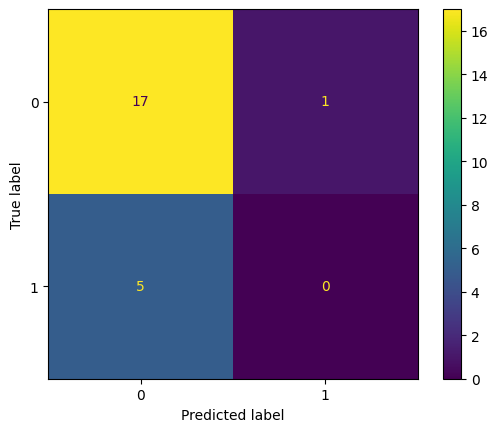

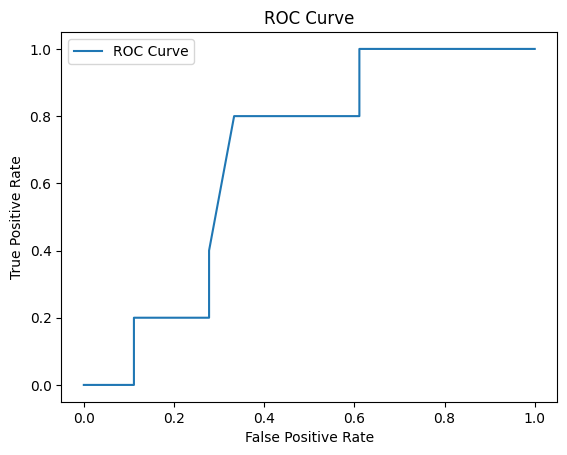

In [11]:
best_model = RandomForestClassifier()
best_model.fit(X_train, y_train)
y_probs = best_model.predict_proba(X_test)[:,1]
y_preds = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Feature Importance Visualization

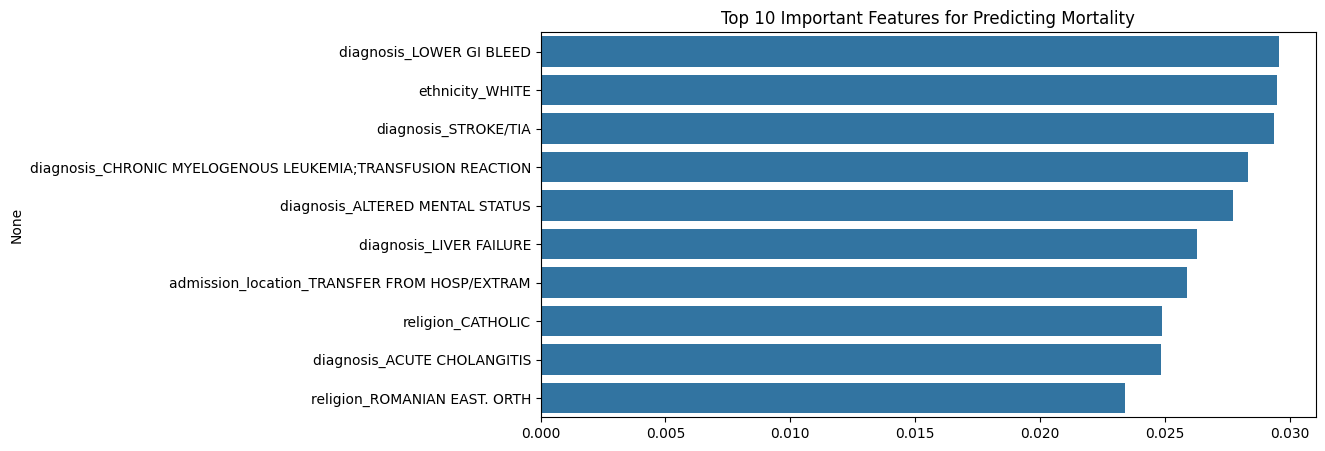

In [12]:
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 10 Important Features for Predicting Mortality')
plt.show()
